In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load the dataset
file_path = 'C:\\Users\\91964\\Desktop\\csp\\customer_support_tickets.csv'
df = pd.read_csv(file_path)

Dataset shape: (8469, 11)

Missing values:
 Customer Age                    0
Customer Gender                 0
Product Purchased               0
Date of Purchase                0
Ticket Type                     0
Ticket Status                   0
Ticket Priority                 0
Ticket Channel                  0
Viewed Ticket                   0
Ticket Solved                   0
Customer Satisfaction Rating    0
dtype: int64

Descriptive statistics:
         Customer Age  Customer Gender Product Purchased Date of Purchase  \
count    8469.000000      8469.000000              8469             8469   
unique           NaN              NaN                42              730   
top              NaN              NaN         Canon EOS       21-10-2020   
freq             NaN              NaN               240               24   
mean       44.026804         0.499587               NaN              NaN   
std        15.296112         0.500029               NaN              NaN   
min        

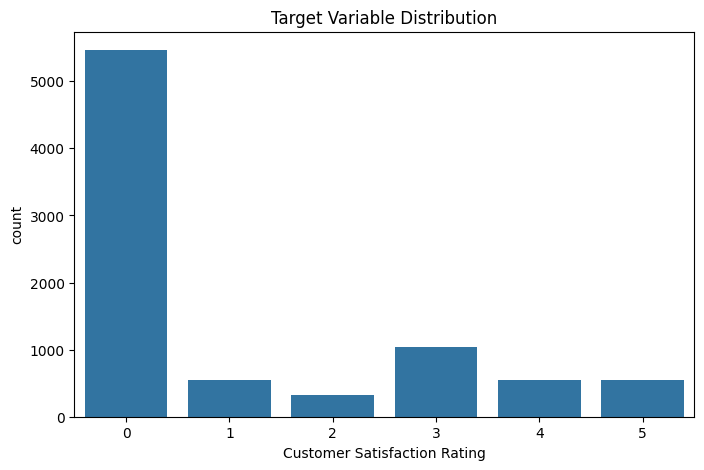

In [6]:
# 1. Enhanced Data Exploration
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nDescriptive statistics:\n", df.describe(include='all'))
# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Customer Satisfaction Rating', data=df)
plt.title('Target Variable Distribution')
plt.show()

In [7]:
# 2. Improved Feature Engineering
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
categorical_columns = ['Product Purchased', 'Ticket Type', 'Ticket Channel']
df[categorical_columns] = imputer.fit_transform(df[categorical_columns])
# Convert date to multiple features
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
df['Purchase_Year'] = df['Date of Purchase'].dt.year
df['Purchase_Month'] = df['Date of Purchase'].dt.month
df['Purchase_Day'] = df['Date of Purchase'].dt.day
df['Purchase_DayOfWeek'] = df['Date of Purchase'].dt.dayofweek
df = df.drop(columns=['Date of Purchase'])

C:\Users\91964\AppData\Local\Temp\ipykernel_10464\441521445.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])


In [8]:
# 3. Advanced Preprocessing
# Separate features and target
X = df.drop('Customer Satisfaction Rating', axis=1)
y = df['Customer Satisfaction Rating']
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [9]:
# 4. Improved Model Training with Cross-Validation
# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Create a pipeline with preprocessing and model
model = make_imb_pipeline(
    preprocessor,
    SMOTE(random_state=42),  # Handle class imbalance
    BalancedRandomForestClassifier(random_state=42, class_weight='balanced')
)

# Expanded hyperparameter grid
param_grid = {
    'balancedrandomforestclassifier__n_estimators': [100, 200, 300],
    'balancedrandomforestclassifier__max_depth': [None, 10, 20, 30],
    'balancedrandomforestclassifier__min_samples_split': [2, 5, 10],
    'balancedrandomforestclassifier__min_samples_leaf': [1, 2, 4],
    'balancedrandomforestclassifier__max_features': ['sqrt', 'log2', 0.5]
}

# Use more CV folds and parallel processing
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
print("\nBest parameters:", grid_search.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'balancedrandomforestclassifier__max_depth': 20, 'balancedrandomforestclassifier__max_features': 'sqrt', 'balancedrandomforestclassifier__min_samples_leaf': 1, 'balancedrandomforestclassifier__min_samples_split': 2, 'balancedrandomforestclassifier__n_estimators': 100}



Test Accuracy: 0.769185360094451

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1093
           1       0.81      0.46      0.59       111
           2       0.11      0.10      0.10        63
           3       0.40      0.48      0.44       209
           4       0.22      0.22      0.22       109
           5       0.23      0.27      0.25       109

    accuracy                           0.77      1694
   macro avg       0.46      0.42      0.43      1694
weighted avg       0.78      0.77      0.77      1694



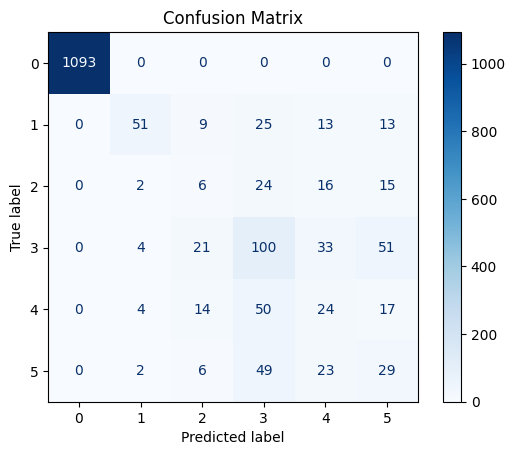

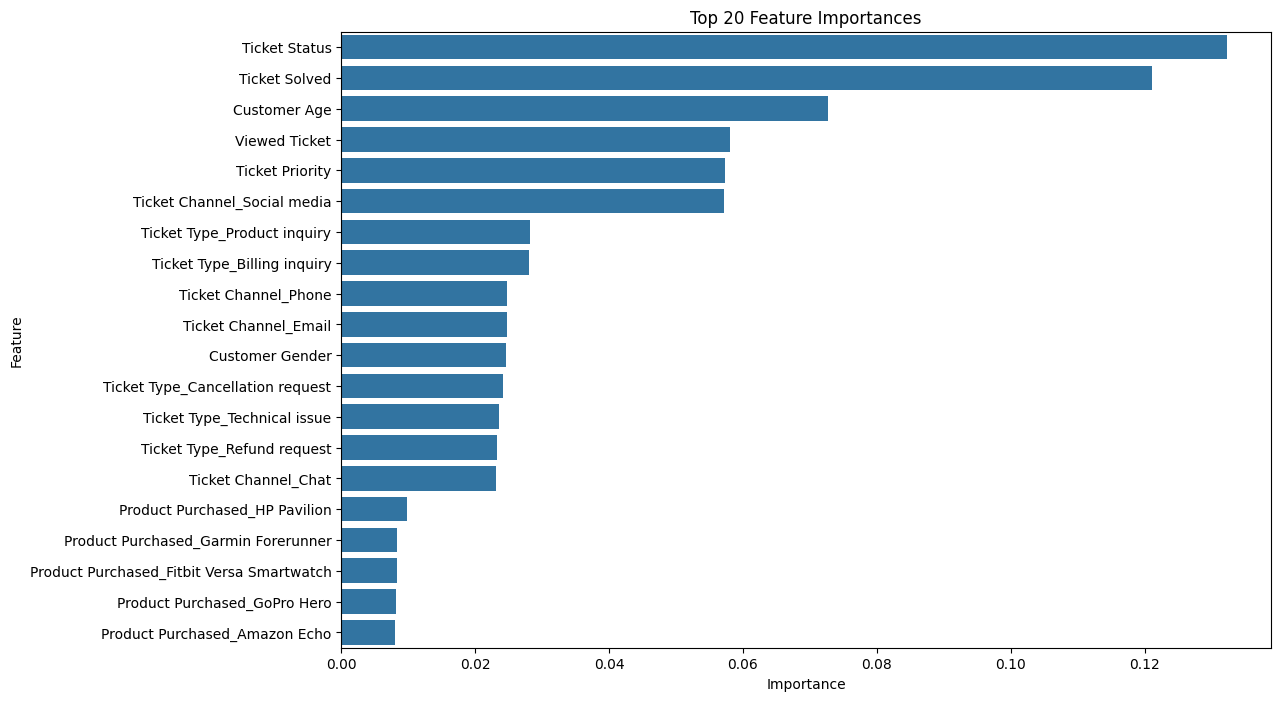

In [10]:
# 5. Enhanced Model Evaluation
# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Feature Importance (for tree-based models)
if hasattr(best_model.named_steps['balancedrandomforestclassifier'], 'feature_importances_'):
    # Get feature names after one-hot encoding
    ohe_feature_names = best_model.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(ohe_feature_names)
    
    importances = best_model.named_steps['balancedrandomforestclassifier'].feature_importances_
    feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importances')
    plt.show()

In [11]:
# 6. Additional Evaluation Metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

print("\nBalanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

# For multiclass ROC AUC (needs probability estimates)
if len(np.unique(y)) > 2:
    y_proba = best_model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    print("\nROC AUC Score (OvR):", roc_auc)
else:
    roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    print("\nROC AUC Score:", roc_auc)


Balanced Accuracy: 0.41990083105486287

ROC AUC Score (OvR): 0.8909562547323563


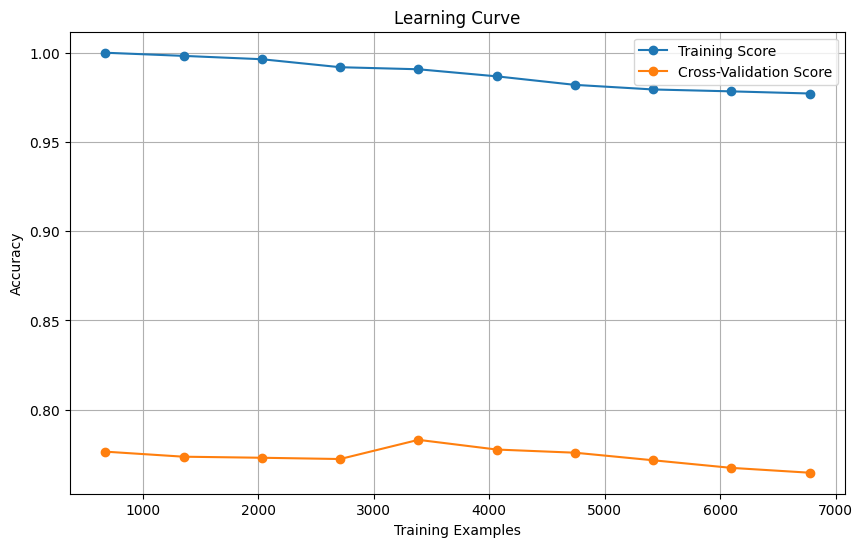

In [12]:
# 7. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [13]:
# 8. Error Analysis
results_df = X_test.copy()
results_df['True_Label'] = y_test.values
results_df['Predicted_Label'] = y_pred
results_df['Correct'] = results_df['True_Label'] == results_df['Predicted_Label']

# Analyze misclassifications
misclassified = results_df[~results_df['Correct']]
print("\nMisclassification patterns:")
print(misclassified.groupby(['True_Label', 'Predicted_Label']).size().unstack().fillna(0))


Misclassification patterns:
Predicted_Label    1     2     3     4     5
True_Label                                  
1                0.0   9.0  25.0  13.0  13.0
2                2.0   0.0  24.0  16.0  15.0
3                4.0  21.0   0.0  33.0  51.0
4                4.0  14.0  50.0   0.0  17.0
5                2.0   6.0  49.0  23.0   0.0


In [14]:
import joblib

# Save the trained pipeline (best_model)
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']

In [16]:
pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Customer Age                  8469 non-null   int64 
 1   Customer Gender               8469 non-null   int64 
 2   Product Purchased             8469 non-null   object
 3   Ticket Type                   8469 non-null   object
 4   Ticket Status                 8469 non-null   int64 
 5   Ticket Priority               8469 non-null   int64 
 6   Ticket Channel                8469 non-null   object
 7   Viewed Ticket                 8469 non-null   int64 
 8   Ticket Solved                 8469 non-null   int64 
 9   Customer Satisfaction Rating  8469 non-null   int64 
 10  Purchase_Year                 8469 non-null   int32 
 11  Purchase_Month                8469 non-null   int32 
 12  Purchase_Day                  8469 non-null   int32 
 13  Purchase_DayOfWeek